<a href="https://colab.research.google.com/github/PWhiddy/jax-experiments/blob/main/nn_from_scratchV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax
import jax.numpy as jnp

In [2]:
from jax import value_and_grad
from jax import grad
from jax import vmap
from jax import jit

In [3]:
jax.device_count()

1

In [4]:
jax.devices()

In [5]:
import jax
key = jax.random.PRNGKey(0)
from numpy import random

In [6]:
import matplotlib.pyplot as plt

In [7]:
from tqdm.notebook import tqdm

In [8]:
#dir(jnp.zeros(5).device())

In [9]:
jnp.zeros(5).device().device_kind

'cpu'

In [10]:
#@title
# from https://github.com/google/jax/blob/main/examples/datasets.py

import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return {'train_img': train_images, 'train_lab': train_labels, 'test_img': test_images, 'test_lab': test_labels}

In [11]:
mnist_dat = mnist()

downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz to /tmp/jax_example_data/
downloaded https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz to /tmp/jax_example_data/


In [12]:
mnist_dat['train_img'][0].shape

(784,)

In [13]:
import matplotlib.pyplot as plt

In [14]:
def show_img(img):
  plt.imshow(img.reshape(28,28))
  plt.colorbar()

9


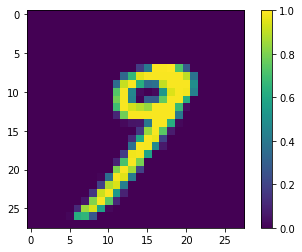

In [15]:
demo_idx = 33
demo_img = mnist_dat['train_img'][demo_idx]
show_img(demo_img)
print(jnp.argmax(mnist_dat['train_lab'][demo_idx]))

In [16]:
#jnp.argmax(model.forward_single(demo_img))

In [17]:
def model_random_predict(img):
  return int(random.random()*10)

In [18]:
model_random_predict('test')

3

In [19]:
def evaluate(pred_func, max=2000, progress_func=lambda x: x):
  correct = 0
  incorrect = 0
  count = 0

  for train_img, train_lab in progress_func(zip(mnist_dat['test_img'][:max], mnist_dat['test_lab'][:max])):
    pred = pred_func(train_img)
    if jnp.argmax(pred) == jnp.argmax(train_lab):
      correct += 1
    else:
      incorrect += 1
    count += 1
    final_stats = {'correct': correct, 'total': count, 'accuracy': correct/count}
    #tqdm.write(str(final_stats))

  return final_stats

In [20]:
evaluate(model_random_predict)

{'accuracy': 0.0875, 'correct': 175, 'total': 2000}

In [21]:
class NNModel:

  def __init__(self, input_size, hidden_size, out_size, ce_loss=False, use_mom=False):

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.out_size = out_size

    self.cross_entropy_loss = ce_loss
    self.momentum = use_mom

    # use normed initialization?
    self.weights_l1 = jnp.array(random.normal(size=(input_size, hidden_size))) / jnp.sqrt(hidden_size)
    self.w1_m = jnp.zeros_like(self.weights_l1)
    self.weights_l2 = jnp.array(random.normal(size=(hidden_size, out_size))) / jnp.sqrt(out_size)
    self.w2_m = jnp.zeros_like(self.weights_l2)
    self.bias_l1 = jnp.array(random.normal(size=(hidden_size,)))
    self.b1_m = jnp.zeros_like(self.bias_l1)
    self.bias_l2 = jnp.array(random.normal(size=(out_size,)))
    self.b2_m = jnp.zeros_like(self.bias_l2)

    @jit
    def forward_single(weights_l1, weights_l2, bias_l1, bias_l2, img):
      # matrix mult, bias, relu activation
      hidden = jnp.maximum(img @ weights_l1 + bias_l1, 0.0)
      out_raw = hidden @ weights_l2 + bias_l2
      # softmax to probability distribution
      out_exp = jnp.e ** out_raw
      out_probs = out_exp / out_exp.sum()
      return out_probs

    @jit
    def loss(w1, w2, b1, b2, img, lab):
      preds = forward_single(w1, w2, b1, b2, img)
      #print(preds)
      #print(lab)
      if self.cross_entropy_loss:
        idx = jnp.argmax(lab)
        return -jnp.log(preds[idx])
      else:
        diffs = (preds-lab) ** 2
        return diffs.mean()

    self.forward_single = lambda img: forward_single(
        self.weights_l1, self.weights_l2, 
        self.bias_l1, self.bias_l2, img)
    
    self.grad_f = value_and_grad(loss, argnums=[0,1,2,3])
    self.grad_func = lambda img, lab: self.grad_f(
        self.weights_l1, 
        self.weights_l2, 
        self.bias_l1, 
        self.bias_l2, 
        img, lab)

    self.batched_loss = vmap(loss, in_axes=(None, None, None, None, 0, 0))

    self._grad_batched = jit(value_and_grad(
        lambda w1, w2, b1, b2, imgs, labs: self.batched_loss(w1, w2, b1, b2, imgs, labs).sum(),
        argnums=[0,1,2,3]
    ))

    self.grad_batched = lambda imgs, labs: self._grad_batched(
            self.weights_l1, self.weights_l2, 
            self.bias_l1, self.bias_l2, imgs, labs)

  def update(self, imgs, labs, lr_a, lr_b):
    #loss, grads = self.grad_func(imgs, labs)
    loss, grads = self.grad_batched(imgs, labs)
    w1_d, w2_d, b1_d, b2_d = grads
    if self.momentum:
      # update momentum
      self.w1_m = lr_b * self.w1_m + w1_d * (1-lr_b)
      self.w2_m = lr_b * self.w2_m + w2_d * (1-lr_b)
      self.b1_m = lr_b * self.b1_m + b1_d * (1-lr_b)
      self.b2_m = lr_b * self.b2_m + b2_d * (1-lr_b)
      # update parameters
      self.weights_l1 -= self.w1_m * lr_a
      self.weights_l2 -= self.w2_m * lr_a
      self.bias_l1 -= self.b1_m * lr_a
      self.bias_l2 -= self.b2_m * lr_a
    else:
      # update parameters
      self.weights_l1 -= w1_d * lr_a #self.w1_m * lr_b
      self.weights_l2 -= w2_d * lr_a #self.w2_m * lr_b
      self.bias_l1 -= b1_d * lr_a #self.b1_m * lr_b
      self.bias_l2 -= b2_d * lr_a #self.b2_m * lr_b
    return loss


In [22]:
def create_fresh_mnist_model(hidden_size=256, use_momentum=False, use_ce_loss=False):
  return NNModel(
      mnist_dat['train_img'][0].shape[0], hidden_size, mnist_dat['train_lab'][0].shape[0],
      ce_loss=use_ce_loss, use_mom=use_momentum)

In [23]:
model = create_fresh_mnist_model()

In [24]:
loss_single, grd_single = model.grad_func(mnist_dat['train_img'][demo_idx], mnist_dat['train_lab'][demo_idx])

In [25]:
for x in grd_single:
  print(x.shape)
  print(x.std())

(784, 256)
6.708858e-05
(256, 10)
0.00022800927
(256,)
0.00022502623
(10,)
0.0003216487


In [26]:
loss_single

DeviceArray(0.19915569, dtype=float32)

In [27]:
loss_b, grd_b = model.grad_batched(mnist_dat['train_img'][demo_idx:demo_idx + 1], mnist_dat['train_lab'][demo_idx:demo_idx + 1])

In [28]:
loss_b

DeviceArray(0.19915569, dtype=float32)

In [29]:
for grds, grdb in zip(grd_single, grd_b):
  print((grds-grdb).sum())

1.7021637e-05
2.6134496e-06
2.0495281e-07
2.6001054e-08


In [30]:
len(mnist_dat['train_img'])

60000

In [31]:
def test_train_performance(train_its, test_interval, test_its, batch_size=16, hidden_size=256, use_momentum=False, use_ce_loss=False, alpha=0.005, beta=0.9):
  mod = create_fresh_mnist_model(hidden_size=hidden_size, use_momentum=use_momentum, use_ce_loss=use_ce_loss)
  accs = []
  for i in tqdm(range(train_its)):
    lb, ub = i*batch_size, (i+1)*batch_size
    #loss = mod.update(mnist_dat['train_img'][i], mnist_dat['train_lab'][i], alpha, beta)
    loss = mod.update(mnist_dat['train_img'][lb:ub], mnist_dat['train_lab'][lb:ub], alpha, beta)
    if i % test_interval == 0:
      accs.append(evaluate(mod.forward_single, max=test_its))
  return {
      'stats': accs, 
      'train_its': train_its, 'test_interval': test_interval, 
      'test_its': test_its, 'hidden_size': hidden_size, 
      'use_momentum': use_momentum, 'use_ce_loss': use_ce_loss, 
      'alpha': alpha, 'beta': beta }

In [32]:
experiments = {}

In [33]:
#experiments['lr_0.005'] = test_train_performance(2500, 500, 200, alpha=0.005)
#experiments['lr_0.015'] = test_train_performance(2500, 500, 200, alpha=0.015)
experiments['lr_0.05_b1'] = test_train_performance(2500, 500, 200, alpha=0.05, batch_size=1)
experiments['lr_0.05'] = test_train_performance(2500, 500, 200, alpha=0.05, batch_size=16)
#experiments['lr_0.1'] = test_train_performance(2500, 500, 200, alpha=0.1)
experiments['lr_0.05_momentum'] = test_train_performance(2500, 500, 200, use_momentum=True, alpha=0.05, beta=0.9, batch_size=1)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [34]:
experiments['lr_0.005_ce_loss'] = test_train_performance(2500, 500, 200, use_ce_loss=True, alpha=0.005)
experiments['lr_0.005_ce_loss_momentum'] = test_train_performance(2500, 500, 200, use_ce_loss=True, use_momentum=True, alpha=0.005, beta=0.9)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [35]:
experiments['lr_0.005_ce_loss_momentum'] = test_train_performance(2500, 500, 200, use_ce_loss=True, use_momentum=True, alpha=0.005, beta=0.9)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [36]:
experiments['lr_0.002_ce_loss_momentum'] = test_train_performance(2500, 500, 200, use_ce_loss=True, use_momentum=True, alpha=0.002, beta=0.9)
experiments['lr_0.002_momentum'] = test_train_performance(2500, 500, 200, use_momentum=True, alpha=0.002, beta=0.9)

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

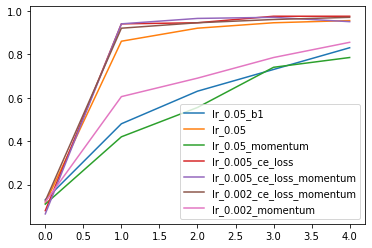

In [37]:
for name, data in experiments.items():
  nums = [s['accuracy'] for s in data['stats']]
  plt.plot(list(range(len(nums))), nums, label=name)
plt.legend()

In [38]:
experiments

{'lr_0.002_ce_loss_momentum': {'alpha': 0.002,
  'beta': 0.9,
  'hidden_size': 256,
  'stats': [{'accuracy': 0.125, 'correct': 25, 'total': 200},
   {'accuracy': 0.92, 'correct': 184, 'total': 200},
   {'accuracy': 0.945, 'correct': 189, 'total': 200},
   {'accuracy': 0.96, 'correct': 192, 'total': 200},
   {'accuracy': 0.97, 'correct': 194, 'total': 200}],
  'test_interval': 500,
  'test_its': 200,
  'train_its': 2500,
  'use_ce_loss': True,
  'use_momentum': True},
 'lr_0.002_momentum': {'alpha': 0.002,
  'beta': 0.9,
  'hidden_size': 256,
  'stats': [{'accuracy': 0.12, 'correct': 24, 'total': 200},
   {'accuracy': 0.605, 'correct': 121, 'total': 200},
   {'accuracy': 0.69, 'correct': 138, 'total': 200},
   {'accuracy': 0.785, 'correct': 157, 'total': 200},
   {'accuracy': 0.855, 'correct': 171, 'total': 200}],
  'test_interval': 500,
  'test_its': 200,
  'train_its': 2500,
  'use_ce_loss': False,
  'use_momentum': True},
 'lr_0.005_ce_loss': {'alpha': 0.005,
  'beta': 0.9,
  'hidden

In [39]:
def funcy(x):
  return jnp.sum(jnp.cos(x)+1.5)**2

def mag(f):
  return lambda x: f(x).mean()

fg = grad(funcy)
bad = grad(grad(funcy))
mega = grad(mag(grad(mag(grad(funcy)))))
inp = jnp.arange(0,10, 0.1, dtype=jnp.float32)
fg(inp)
mega(inp)

DeviceArray([ 0.00745896,  0.01023635,  0.01291147,  0.01545758,
              0.01784924,  0.02006255,  0.02207541,  0.0238677 ,
              0.02542151,  0.02672132,  0.02775414,  0.02850964,
              0.02898029,  0.02916138,  0.0290511 ,  0.02865054,
              0.02796372,  0.0269975 ,  0.02576152,  0.02426815,
              0.02253229,  0.0205713 ,  0.01840477,  0.01605435,
              0.01354351,  0.01089735,  0.00814231,  0.00530592,
              0.00241651, -0.00049705, -0.00340564, -0.0062802 ,
             -0.00909201, -0.01181298, -0.01441592, -0.01687481,
             -0.0191651 , -0.0212639 , -0.02315024, -0.02480526,
             -0.02621244, -0.02735771, -0.02822964, -0.02881951,
             -0.02912141, -0.02913235, -0.02885221, -0.02828378,
             -0.02743276, -0.02630763, -0.02491965, -0.02328268,
             -0.02141306, -0.01932951, -0.01705282, -0.01460574,
             -0.01201273, -0.00929968, -0.00649372, -0.00362288,
             -0.00071584,

In [40]:
def proc_vec(va, vb):
  return va.mean() + vb.mean()

b_vec = vmap(value_and_grad(proc_vec))

ina = jax.random.normal(key, (16, 1784))
inb = jax.random.normal(key, (16, 64))

b_vec(ina, inb)
#proc_vec(jnp.arange(10, dtype=jnp.float32))

(DeviceArray([ 0.2241556 , -0.05757523,  0.01883693, -0.0598987 ,
              -0.09484608,  0.03803565,  0.00765744,  0.1863282 ,
              -0.0364951 ,  0.04670619,  0.13426849,  0.10754545,
              -0.05629355, -0.16495667,  0.06950187,  0.18095963],            dtype=float32),
 DeviceArray([[0.00056054, 0.00056054, 0.00056054, ..., 0.00056054,
               0.00056054, 0.00056054],
              [0.00056054, 0.00056054, 0.00056054, ..., 0.00056054,
               0.00056054, 0.00056054],
              [0.00056054, 0.00056054, 0.00056054, ..., 0.00056054,
               0.00056054, 0.00056054],
              ...,
              [0.00056054, 0.00056054, 0.00056054, ..., 0.00056054,
               0.00056054, 0.00056054],
              [0.00056054, 0.00056054, 0.00056054, ..., 0.00056054,
               0.00056054, 0.00056054],
              [0.00056054, 0.00056054, 0.00056054, ..., 0.00056054,
               0.00056054, 0.00056054]], dtype=float32))